<a href="https://colab.research.google.com/github/Neo-glitch/computer-vision-masterclass/blob/main/Object_Localization_using_Tensorflow_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import binary_crossentropy
from skimage.transform import resize
import cv2
from google.colab.patches import cv2_imshow

### **Object Localization of Charmander capable of handling no object found scenarios**

In [1]:
# run this first before running cell for importing libraries
# to avoid 401 error (don't know why this happens though, I will look into this)
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2023-02-12 20:16:51--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2023-02-12 20:16:51 (52.1 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



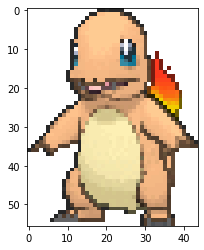

In [3]:
ch = imageio.imread('charmander-tight.png')
plt.imshow(ch)
plt.show()

In [4]:
# init variables to be used

POKE_DIM = 200
ch = np.array(ch)
CH_H, CH_W, CH_C = ch.shape

In [5]:
# helper function to crate our custom loss
def custom_loss(y_true, y_pred):
  """
  bce = Binary Cross Entropy of bounding box
  bce2 = Binary Cross Entropy of prob of object being found
  target is a tuple of len 5 i.e(y, x, h, w, object_found)
  loss is =  (alpha * bce * obj_appeared (i.e 1 or 0)) + (beta * bce2)
  """
  bce = binary_crossentropy(y_true[:, :-1], y_pred[:, :-1])
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1])
  alpha = 2
  beta = 0.5
  return alpha * bce * y_true[:, -1] + beta * bce2


# helper function for making the model
def make_model():
  vgg = tf.keras.applications.VGG16(
  input_shape=[POKE_DIM, POKE_DIM, 3],
    include_top=False,
    weights='imagenet')
  
  vgg.trainable = False  # freeze vgg layes

  x = Flatten()(vgg.output)
  x = Dense(5, activation='sigmoid')(x)
  model = Model(vgg.input, x)

  model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.0001))
  return model

In [6]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2023-02-12 20:18:28--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K  1.61MB/s    in 0.3s    

2023-02-12 20:18:29 (1.61 MB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [7]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

In [8]:
from glob import glob

background_files = glob('backgrounds/*.jpg')
backgrounds = [np.array(image.load_img(f)) for f in background_files]

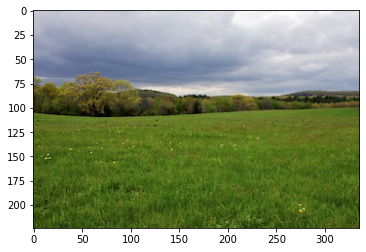

In [9]:
plt.imshow(backgrounds[6])

In [10]:
def pokemon_generator_bg(batch_size = 64):
  while True:
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 5))  # 5 since last element determines if object in image

      for i in range(batch_size):
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w = bg.shape[:2]

        # ensures each background used is of dim POKE_DIM x POKE_DIM
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()

        # decides random when to place charmander image in background
        appear = (np.random.random() < 0.5)
        if appear:
          # resize charmander - make it bigger or smaller
          scale = 0.5 + np.random.random()
          new_height = int(CH_H * scale)
          new_width = int(CH_W * scale)
          obj = resize(
              ch,
              (new_height, new_width),
              preserve_range=True).astype(np.uint8) # keep it from 0..255

          # maybe flip
          if np.random.random() < 0.5:
            obj = np.fliplr(obj)

          # choose a random location to store the object
          row0 = np.random.randint(POKE_DIM - new_height)
          col0 = np.random.randint(POKE_DIM - new_width)
          row1 = row0 + new_height
          col1 = col0 + new_width

          # can't 'just' assign obj to a slice of X
          # since the transparent parts will be black (0)
          mask = (obj[:,:,3] == 0) # find where the pokemon is 0
          bg_slice = X[i,row0:row1,col0:col1,:] # where we want to place `obj`
          bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
          bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
          X[i,row0:row1,col0:col1,:] = bg_slice # put the slice back

          # make targets
          Y[i,0] = row0/POKE_DIM
          Y[i,1] = col0/POKE_DIM

          # later: make the pokemon different sizes
          Y[i,2] = (row1 - row0)/POKE_DIM
          Y[i,3] = (col1 - col0)/POKE_DIM

        # did the pokemon appear? if yes value = 1 else 0
        Y[i,4] = appear

      yield X / 255., Y


Is object found: False



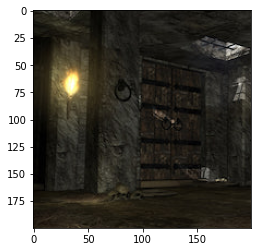

In [11]:
# test our generator
xx = None
yy = None
for x, y in pokemon_generator_bg():
  xx, yy = x, y
  break

plt.imshow(xx[6])
print(f"Is object found: {True if yy[6][-1] == 1 else False}\n")

In [12]:
model = make_model()
model.fit(
    pokemon_generator_bg(),
    steps_per_epoch = 50,
    epochs = 12
)

58889256/58889256 [==============================] - 0s 0us/step


Epoch 1/12
50/50 [==============================] - 25s 233ms/step - loss: 0.7895
Epoch 2/12
50/50 [==============================] - 16s 324ms/step - loss: 0.6154
Epoch 3/12
50/50 [==============================] - 13s 259ms/step - loss: 0.5902
Epoch 4/12
50/50 [==============================] - 12s 241ms/step - loss: 0.5905
Epoch 5/12
50/50 [==============================] - 12s 248ms/step - loss: 0.5705
Epoch 6/12
50/50 [==============================] - 13s 255ms/step - loss: 0.5836
Epoch 7/12
50/50 [==============================] - 13s 263ms/step - loss: 0.5800
Epoch 8/12
50/50 [==============================] - 13s 266ms/step - loss: 0.5663
Epoch 9/12
50/50 [==============================] - 13s 255ms/step - loss: 0.5695
Epoch 10/12
50/50 [==============================] - 13s 251ms/step - loss: 0.5727
Epoch 11/12
50/50 [==============================] - 13s 256ms/step - loss: 0.5688
Epoch 12/12
50/50 [==============================] - 13s 253ms/step - loss: 0.5510


In [13]:
# make predictions
def pokemon_prediction_bg():
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
  
  appear = (np.random.random() < 0.5)

  if(appear):
    # resize charmander - make it bigger or smaller
    scale = 0.5 + np.random.random()
    new_height = int(CH_H * scale)
    new_width = int(CH_W * scale)
    obj = resize(
        ch,
        (new_height, new_width),
        preserve_range=True).astype(np.uint8) # keep it from 0..255

    # maybe flip
    if np.random.random() < 0.5:
      obj = np.fliplr(obj)

    # choose a random location to store the object
    row0 = np.random.randint(POKE_DIM - new_height)
    col0 = np.random.randint(POKE_DIM - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width

    # can't 'just' assign obj to a slice of X
    # since the transparent parts will be black (0)
    mask = (obj[:,:,3] == 0) # find where the pokemon is 0
    bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
    bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
    x[row0:row1,col0:col1,:] = bg_slice # put the slice back
    print("true:", row0, col0, row1, col1)


  # Predict
  X = x[np.newaxis, ...] / 255.
  p = model.predict(X)[0]

  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))


  if p[4] > 0.5:
    # if prob of object being in image is > 0.5
    row0 = int(p[0] * POKE_DIM)
    col0 = int(p[1] * POKE_DIM)
    row1 = int(row0 + p[2] * POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    print("pred:", row0, col0, row1, col1)
    
    rect = Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  else:
    print("pred: no object")
  plt.show()

true: 107 147 168 194
1/1 [==============================] - 0s 26ms/step
pred: 105 146 168 194


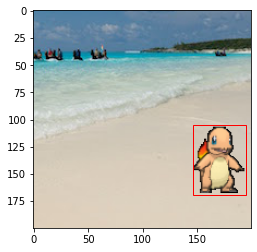

In [24]:
pokemon_prediction_bg()

#### **Object Localization of multiples charmanda objects**